# The Expectation Maximization (EM) Algorithm
EM is an iterative procedure for obtaining maximum likeliood (ML) estimates. Suppose that $X$ is distributed according to the pdf $f_X(\cdot;\theta)$, where $\theta$ is an unknown parameter of interest. Suppose also that we have $n$ independent samples from $f_X$ as, $x = ( x_1, \ldots, x_n)$. Given $x$, recall that the ML estimate is the maximizer of the likelihood function $L(\cdot) = f_X(x;\cdot)$, and is given by,
$$\hat{\theta} = \arg \max_{t} \left\{L(t) = f_X(x;t) := \prod_{i=1}^n f_X(x_i; t) \right\}. $$
When $L(t)$ has a simple expression, the ML estimate can be obtained analytically. However, in many scenarios of interest, this is not the case. EM is an iterative procedure for finding a local maximum of $L(\cdot)$.
#### Example
Suppose $Z$ is a Bernoulli random variable with PMF
$$ P_Z(z) = \begin{cases}\alpha_0, &\text{if }z = 1,\\
\alpha_1 = 1-\alpha_0, &\text{if }z=0,
\end{cases}$$
where $\alpha_0$ is an (unknown) constant.
Given a realization of $Z$ as $z$, suppose $X$ is given as,
$$X = \begin{cases}
w  + \theta_0, &\text{if } z=0,\\
w  + \theta_1, &\text{if } z=1,
\end{cases}$$
where $w \sim \mathcal{N}(0,1)$ and $\theta_i$ are unknown. Note that the distribution of $X$ is 
$$ f_X(x) = \alpha_0\, g(x;\theta_0) + \alpha_1 \,g(x;\theta_1),$$
where
$$g(x;\theta) = \frac{1}{\sqrt{2\pi}} \exp\left( -\frac{1}{2} (x - \theta)^2  \right). $$

Suppose we are given independent realizations of $X$ and asked to estimate $\alpha_i$ and $\theta_i$. Notice that here, $z_i$'s are unknown to us (constituting the hidden states, according to hidden Markov models terminology). Let us produce such a set of $x_i$'s. In order to hide $\alpha_i$'s and $\theta_i$'s, we also select them randomly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

n = 1000 #number of samples
alp0 = np.random.uniform(0,1,1)
alp1 = 1 - alp0
theta = np.random.normal(0,5,2)
z = np.double( np.random.uniform(0,1,n) > alp0 )
x = z * np.random.normal(theta[0],1,n) + (1-z) * np.random.normal(theta[1],1,n)

In the following, we pretend that we just observe $x$. Let us view the histogram of the data.

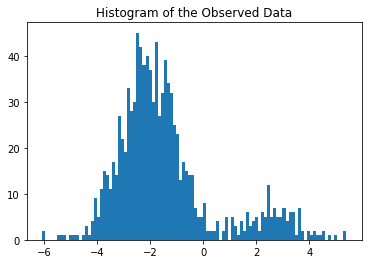

In [2]:
plt.hist(x,100)
plt.title("Histogram of the Observed Data")
plt.show()

Unless the $\theta$ values are very close or one of $\alpha$ is close to unity, we should see two modes, possibly with different weights.

We will see in the following that if we knew $z_i$'s, maximizing the likelihood function wrt $\alpha_i$ and $\theta_i$ is much easier. The idea in EM, to be detailed below, is to estimate, in an iterative manner, $z_i$'s as well as the unknown parameters $\alpha_i$, $\theta_i$.

Let us now consider the hypothetical case where both $x_i$'s and $z_i$'s are known. Given $z_i$'s let $I_0$ and $I_1$ denote the set of indices such that
$$ z_i = \begin{cases} 0, &\text{if } i\in I_0,\\ 
1, &\text{if } i\in I_1. \end{cases}$$
Note that $I_0 \cup I_1 = \{1,2,\ldots, n\}$.
The likelihood function in this case is denoted as $\tilde{L}(\alpha, \theta)$, and is given as,
$$\tilde{L}(a, t) = a_0^{|I_0|}\,a_1^{|I_1|}\,\frac{1}{(2\pi)^{n/2}}\,\exp\left( -\frac{1}{2} \sum_{i \in I_0} (x_i - t_0)^2 + \sum_{i\in I_1} (x_i - t_1)^2\right),$$
where $|I_i|$ denotes the number of elements in $I_i$. Note that $|I_1| = n - |I_0|$. Using this as well as $\alpha_1 = 1 - \alpha_0$, we can write the log-likelihood function as,
$$ \ln \tilde{L}(a,t) = |I_0|\,\ln(a_0) + (n-|I_0|)\,\ln(1-a_0) -\frac{1}{2}\,\sum_{i \in I_0} (x_i - t_0)^2 -\frac{1}{2} \sum_{i\in I_1} (x_i - t_1)^2.$$
Setting the gradient of this function to zero, we obtain the following set of equations

\begin{align}
\frac{|I_0|}{\hat{\alpha}_0} - \frac{n-|I_0|}{1 - \hat{\alpha}_0} &= 0,\\
\sum_{i \in I_0} ( \hat{\theta}_0 - x_i) &= 0,\\
\sum_{i \in I_1} ( \hat{\theta}_1 - x_i) &= 0.
\end{align}

Solving for the unknowns, we obtain the maximizers

\begin{align}
\hat{\alpha}_0 &= \frac{|I_0|}{n},\\
\hat{\theta}_0 &= \frac{1}{|I_0|} \sum_{i \in I_0} x_i,\\
\hat{\theta}_1 &= \frac{1}{n - |I_0|} \sum_{i \in I_1} x_i.
\end{align}

However, when knowledge about $z$ is missing, the ML estimates of $\alpha_i$ and $\theta_i$ are not easy to obtain. The idea in EM is to estimate the the log likelihood with the full data (including $z$) using the current estimates of $\alpha_i$, $\theta_i$, and then use this estimated log-likelihood function to re-estimate (or, update the estimates of) $\alpha_i$ and $\theta_i$. More precisely, suppose we have the observations $x_i$ and our current estimates of the unknown parameters are $\hat{a}_i$, $\hat{t}_i$. Then, instead of $\ln \tilde{L}(a,t)$, consider the function 

\begin{align} 
Q(a,t;\hat{a},\hat{t}) &= \mathbb{E}_{\hat{a},\hat{t}}\left( \ln \tilde{L}(a,t)\right)\\
&= \sum_z \ln \tilde{L}(a,t)\,P_{Z|X}(z|x;\hat{a},\hat{t})
%&= \sum_z \left(|I_0|\,\ln(a_0) + (n-|I_0|)\,\ln(1-a_0) -\frac{1}{2}\,\sum_{i \in I_0} (x_i - t_0)^2 -\frac{1}{2} \sum_{i\in I_1} (x_i - t_1)^2 \right)\,P_{Z|X}(z|x;\hat{a},\hat{t})
\end{align}

Notice that, here the expectation is computed using the PMF of $z$ given $x$ by taking the parameters $\alpha$ and $\theta$ as $\hat{a}$ and $\hat{t}$. Observe also that this gives a function $Q(a,t;\hat{a},\hat{t})$ that depends only on $a_i$ and $t_i$. We maximize this function of $a$ and $t$ to update the desired parameters. That is our new estimates of $\alpha$ and $\theta$ are given as,
$$ (\hat{a},\hat{t}) := \arg \max_{a,t}\,Q(a,t;\hat{a},\hat{t}).$$
Then we repeat the procedure over to further refine our estimates and continue ad infinitum. This is the expectation maximization algorithm.

For our problem, we can express $Q(a,t;\hat{a},\hat{t})$ as follows.

\begin{align} 
Q(a,t;\hat{a},\hat{t})
&= \sum_z \ln \tilde{L}(a,t)\,P_{Z|X}(z|x;\hat{a},\hat{t})\\
&= \sum_z \left(|I_0|\,\ln(a_0) + (n-|I_0|)\,\ln(1-a_0) -\frac{1}{2}\,\sum_{i \in I_0} (x_i - t_0)^2 -\frac{1}{2} \sum_{i\in I_1} (x_i - t_1)^2 \right)\,P_{Z|X}(z|x;\hat{a},\hat{t})
\end{align}

Observe also that, taking into account the fact that $z_i$ can only take values from $\{0,1\}$, we can write the term inside the parentheses as,
$$ \left(n - \sum_i z_i \right) \, \ln(a_0) + \left(\sum_i z_i \right)\,\ln(1-a_0) - \frac{1}{2}\sum_i (1-z_i)\,(x_i - t_0)^2 - \frac{1}{2}\sum_i z_i\, (x_i - t_1)^2
$$
Therefore, if we set 
$e_i = \mathbb{E}_{\hat{a},\hat{t}}(z_i|x_i)$, then
we can express 
$Q(a,t;\hat{a},\hat{t})$, as
$$Q(a,t;\hat{a},\hat{t}) = \left(n - \sum_i e_i \right) \, \ln(a_0) + \left(\sum_i e_i \right)\,\ln(1-a_0) - \frac{1}{2}\sum_i (1-e_i)\,(x_i - t_0)^2 - \frac{1}{2}\sum_i e_i\, (x_i - t_1)^2.$$
I leave it to you to verify that
$$\mathbb{E}_{\hat{a},\hat{t}}(z_i|x_i) = \frac{(1-\hat{a}_0)\,g(x_i;\hat{t}_1)}{\hat{a}_0\,g(x_i;\hat{t}_0) + (1-\hat{a}_0)\,g(x_i;\hat{t}_1)}$$ 

Notice that this number can be computed since it depends solely on what is given ($x_i$) and the current estimates $\hat{a}_i$, $\hat{t}_i$. To simplify expressions, also let $s = \sum_i e_i$. Then, we can write
$$Q(a,t;\hat{a},\hat{t}) = \left(n - s \right) \, \ln(a_0) + \left(s \right)\,\ln(1-a_0) - \frac{1}{2}\sum_i (1-e_i)\,(x_i - t_0)^2 - \frac{1}{2}\sum_i e_i\, (x_i - t_1)^2.$$
Setting the gradient of this function with respect to $a$, $t$ to zero, we obtain the following set of equations that the maximizers $\bar{a}$, $\bar{t}$ should satisfy.

\begin{align}
\frac{n-s}{\bar{a}_0} - \frac{s}{\bar{a}_0} &= 0,\\
\sum_{i=1}^n (1-e_i)\,(\bar{t}_0 - x_i) &= 0,\\
\sum_{i=1}^n e_i\,(\bar{t}_1 - x_i) &= 0.
\end{align}

Solving for the unknowns, we find the maximizers as

\begin{align}
\bar{a}_0 &= \frac{n-s}{n},\\
\bar{t}_0 &= \frac{1}{n-s}\,\sum_{i}^n (1-e_i)\,x_i,\\
\bar{t}_1 &= \frac{1}{s}\,\sum_{i}^n e_i\,x_i,\\
\end{align}

We update $\hat{a} := \bar{a}$, $\hat{t} := \bar{t}$ and repeat the procedure over.

Let us now experiment numerically.

In [3]:
# the Gaussian pdf
def g( x , m ):
    return ( 1 / np.sqrt( 2 * np.pi ) ) * np.exp( -0.5 * ( x - m )**2 )

# the Gaussian mixture pdf
def f( x , t , a):
    return a * g( x , t[0] ) + ( 1 - a ) * g( x , t[1] )

# initialize
a = 0.5
t = [ -1 , 1 ]

for iter in range(0,1000):
    
    # the expectation step
    e = ( 1 - a ) * g( x, t[1] ) / f( x , t , a ) 
    s = sum(e)
    
    # maximization step
    a = ( n - s ) / n # update the weight parameter
    t[0] = sum( ( 1 - e ) * x ) / ( n - s )
    t[1] = sum( e * x ) / s

That's it. We now have our estimates of $\alpha$ and $\theta$. Let's sketch the resulting Gaussian mixture pdf to see how well it matches the normalized histogram.

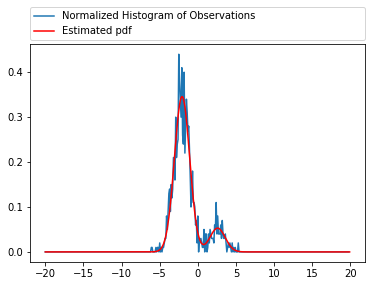

In [4]:
u = np.arange( -20 , 20 , 0.1 )
h , u = np.histogram( x , u , density = True )
plt.plot( u[0:-1] , h , label = "Normalized Histogram of Observations" )
plt.plot( u , f( u , t , a ) , 'r-' , label = "Estimated pdf" )
plt.legend( bbox_to_anchor = (0. , 1.02 , 1. , .102) , loc = 3 , mode = "expand" , borderaxespad = 0.)
plt.show()

*Ilker Bayram, Istanbul Teknik Universitesi, 2016*